In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Initialize Mediapipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Load and resize images
def load_and_resize_image(image_path, size=(400, 400)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = cv2.resize(img, size)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Extract face landmarks
def get_landmarks(image):
    results = face_mesh.process(image)
    if not results.multi_face_landmarks:
        raise ValueError("No face detected in the image!")
    landmarks = results.multi_face_landmarks[0].landmark
    height, width = image.shape[:2]
    points = [(int(lm.x * width), int(lm.y * height)) for lm in landmarks]
    return np.array(points, dtype=np.float32)

# Delaunay triangulation
def delaunay_triangulation(points):
    tri = Delaunay(points)
    return tri.simplices

# Apply affine transformation for each triangle
def apply_affine_transform(src, src_tri, dst_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(dst_tri))
    return cv2.warpAffine(src, warp_mat, (size[1], size[0]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

# Morph images
def morph_image(img1, img2, points1, points2, triangles, alpha):
    points = (1 - alpha) * points1 + alpha * points2
    morphed_img = np.zeros_like(img1, dtype=np.float32)

    for tri in triangles:
        p1 = points1[tri].astype(np.float32)
        p2 = points2[tri].astype(np.float32)
        p = ((1 - alpha) * p1 + alpha * p2).astype(np.float32)

        r = cv2.boundingRect(p)
        p1_crop = p1 - np.array([r[0], r[1]], dtype=np.float32)
        p2_crop = p2 - np.array([r[0], r[1]], dtype=np.float32)
        p_crop = p - np.array([r[0], r[1]], dtype=np.float32)

        img1_crop = img1[r[1]:r[1]+r[3], r[0]:r[0]+r[2]].astype(np.float32)
        img2_crop = img2[r[1]:r[1]+r[3], r[0]:r[0]+r[2]].astype(np.float32)

        warped1 = apply_affine_transform(img1_crop, p1_crop, p_crop, (r[3], r[2]))
        warped2 = apply_affine_transform(img2_crop, p2_crop, p_crop, (r[3], r[2]))

        morphed_crop = (1 - alpha) * warped1 + alpha * warped2

        mask = np.zeros((r[3], r[2]), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(p_crop), 1.0, 16, 0)
        mask = mask[:, :, np.newaxis]  # expand to (h, w, 1)

        morphed_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += morphed_crop * mask

    return np.clip(morphed_img, 0, 255).astype(np.uint8)


def show_morph_result(img1, img2, points1, points2, triangles, alpha=0.5):

    morphed = morph_image(img1, img2, points1, points2, triangles, alpha)
    
    combined = np.hstack((img1, img2, morphed))
    
    plt.figure(figsize=(12, 4))
    plt.imshow(combined)
    plt.axis('off')
    plt.title(f'Face1 | Face2 | Morphed (α={alpha:.2f})')
    plt.show()

# Display morph sequence
def display_morph_sequence(img1, img2, points1, points2, triangles, num_frames=10):
    plt.figure(figsize=(15, 3))
    for i in range(num_frames + 1):
        alpha = i / num_frames
        print(f"Generating frame {i} with alpha={alpha:.2f}")
        morphed = morph_image(img1, img2, points1, points2, triangles, alpha)
        plt.subplot(1, num_frames + 1, i + 1)
        plt.imshow(morphed)
        plt.axis('off')
        plt.title(f'α={alpha:.2f}')
    plt.tight_layout()
    plt.show()



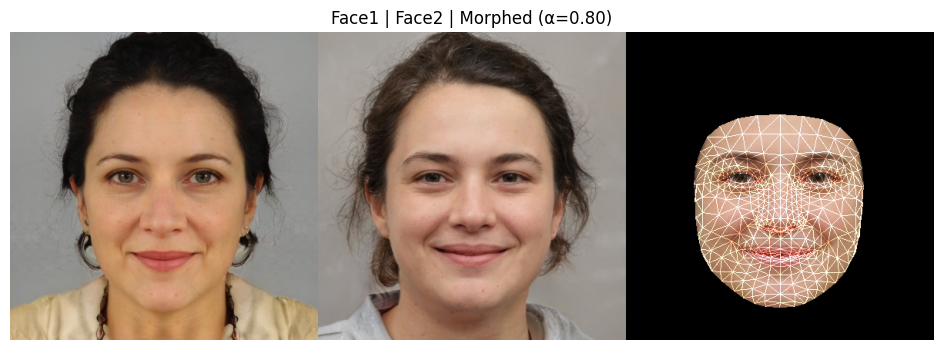

Generating frame 0 with alpha=0.00
Generating frame 1 with alpha=0.10
Generating frame 2 with alpha=0.20
Generating frame 3 with alpha=0.30
Generating frame 4 with alpha=0.40
Generating frame 5 with alpha=0.50
Generating frame 6 with alpha=0.60
Generating frame 7 with alpha=0.70
Generating frame 8 with alpha=0.80
Generating frame 9 with alpha=0.90
Generating frame 10 with alpha=1.00


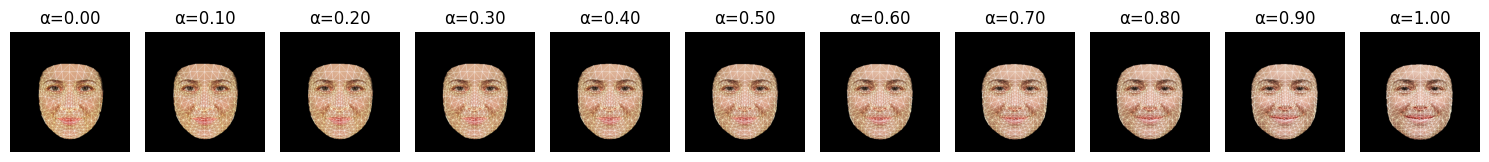

In [3]:
# Load images
img1 = load_and_resize_image('face2.jpg')
img2 = load_and_resize_image('face3.jpg')

# Extract landmarks
points1 = get_landmarks(img1)
points2 = get_landmarks(img2)

# Get Delaunay triangles
triangles = delaunay_triangulation(points1)

# Display morphing sequence
show_morph_result(img1, img2, points1, points2, triangles, alpha=0.8)
display_morph_sequence(img1, img2, points1, points2, triangles, num_frames=10)